In [1]:
#Stock Market Prediction
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00


In [2]:
#Imports & data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # %matplotlib inline
import pmdarima as pm
print(f"Using pmdarima {pm.__version__}") # Using pmdarima 1.5.2
import yfinance as yf
from pandas.plotting import lag_plot
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

Using pmdarima 2.0.4


In [3]:
symbol = 'BTC-USD'
period='10y'
ticker = yf.Ticker(symbol)
df  = ticker.history(period)
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date']) #convert to datetime
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d') #format as YYYY-MM-DD
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


In [4]:
#Data splitting
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data['Close'].values
y_test = test_data['Close'].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

2705 train samples
677 test samples


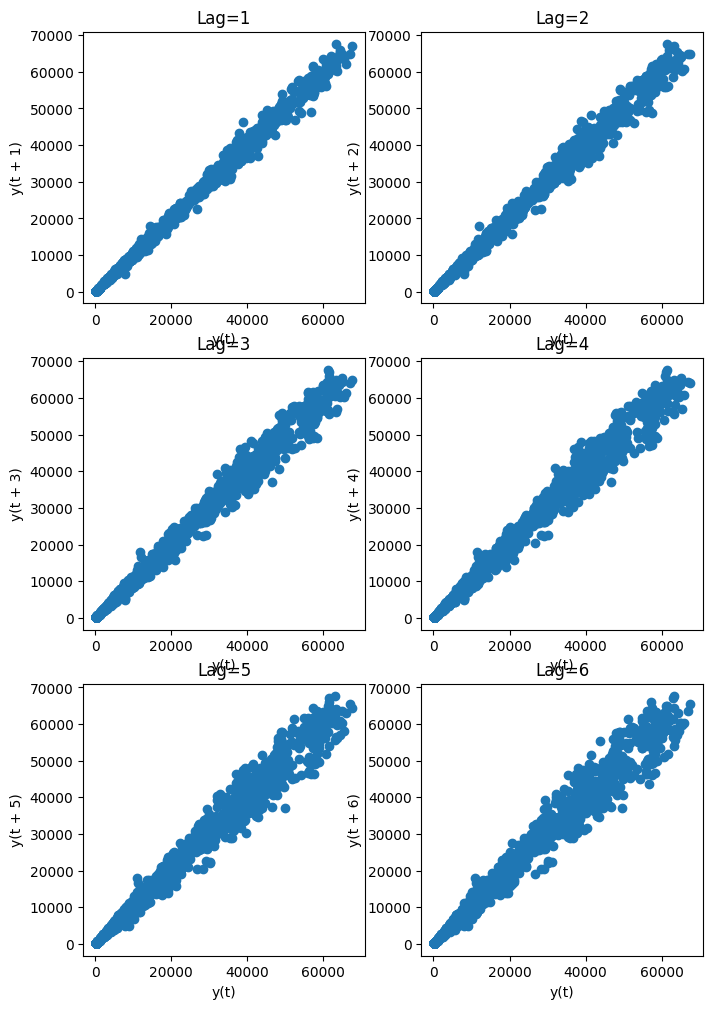

In [5]:
#Pre-modeling analysis
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title('Stock Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df['Close'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

In [6]:
#Estimating the differencing term
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}") # Estimated differencing term: 1

Estimated differencing term: 1


In [7]:
#Fitting our model
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=43624.647, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43625.038, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43625.048, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43623.743, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=43627.039, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.668 seconds


In [8]:
print(auto.order) # (0, 1, 0)

(0, 1, 0)


In [9]:
#Updating the model
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}") # Mean squared error: 0.34238951346274243
print(f"SMAPE: {smape(y_test, forecasts)}") # SMAPE: 0.9825490519101439

Mean squared error: 677827.03802324
SMAPE: 1.8851459052905797


In [10]:
data_count = df['Date'].shape[0]  # The first element of the shape tuple represents the number of rows

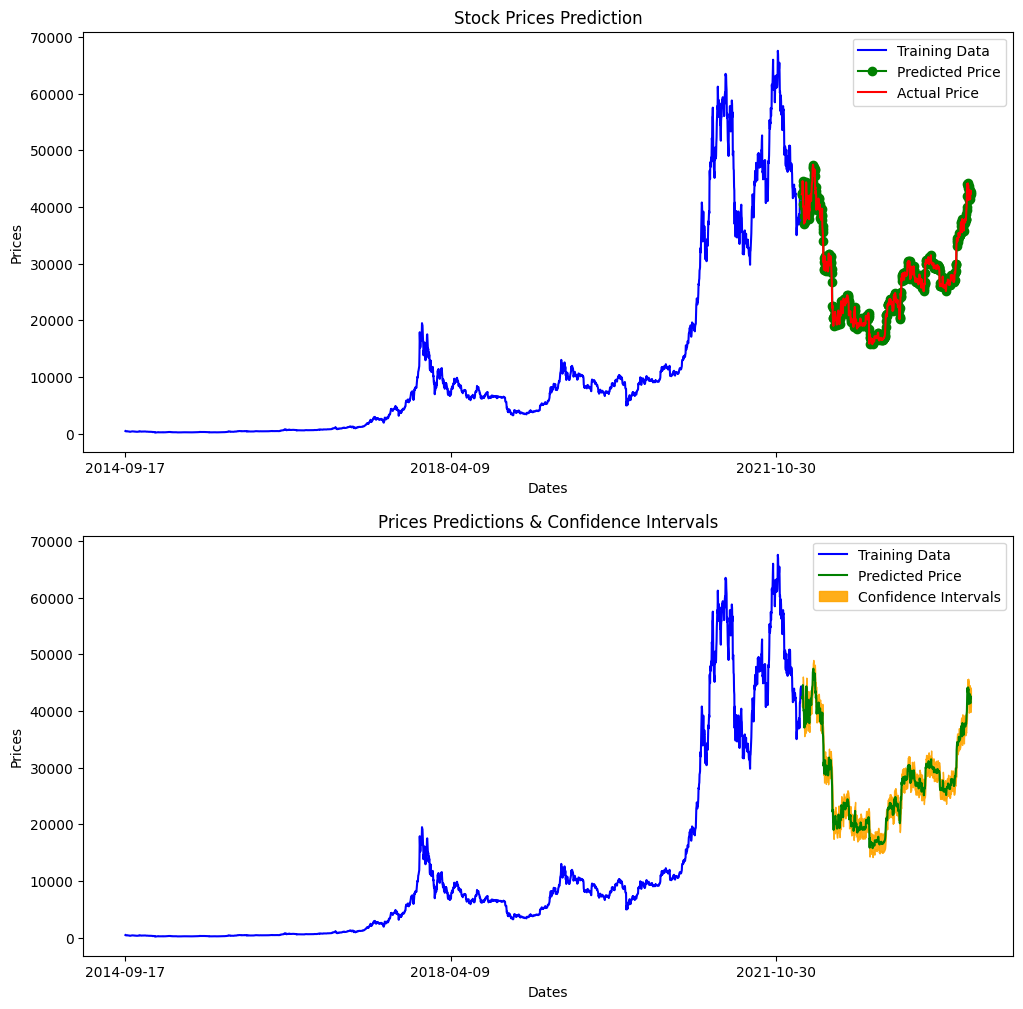

In [11]:
#Viewing forecasts
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Stock Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].set_xticks(np.arange(0, data_count, 1300).tolist(), df['Date'][0:data_count:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].set_xticks(np.arange(0, data_count, 1300).tolist(), df['Date'][0:data_count:1300].tolist())
axes[1].legend()